# Clustering Individual Household Electric Power Consumption and Future Consumption Regression Analysis.

Our group proposes to use the Individual household electric power consumption data set to look for power consumption trends over time. We plan on clustering the data using descriptive methods to discover patterns and trends. Applying predictive methods such as regression we plan to predict future power consumption.

Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from datetime import datetime
from numpy.linalg import norm
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

# Preprocessing

## Process and clean the data
Process the data by reading each line, removing the column header information and stripping the semicolon seperators. Then convert the date and time stamps to numeric values and merge the two to have a dataset with all numeric values.

In [2]:
def time_to_ratio(time_stamp):
    time = datetime.strptime(time_stamp, '%d/%m/%Y %H:%M:%S')
    start = datetime(year=time.year, month=1, day=1)
    end = datetime(year=time.year+1, month=1, day=1)
    return (time - start).total_seconds()/(end - start).total_seconds()

def minutes_from_start(time_stamp, start_stamp):
    time = datetime.strptime(time_stamp, '%d/%m/%Y %H:%M:%S')
    start = datetime.strptime(start_stamp, '%d/%m/%Y %H:%M:%S')
    return (time - start).total_seconds()/60.0

In [3]:
# read data from text document
with open('household_power_consumption.txt', 'r', encoding='utf-8') as f:
    lines = [line.rstrip('\n') for line in f]

# Remove the '?' uncaptured data if detected
data_raw_reduced = [line for line in lines if '?' not in line] 

# strip the header information and remove semicolons     
data_raw = [l.split(';') for l in data_raw_reduced][1::]

# Convert date and time to a numeric value/ratio
time_ratios = [time_to_ratio(f'{t[0]} {t[1]}') for t in data_raw]

# merge time with raw data removing time stamp strings and replacing with ratios
data_time_raw = [[t, float(gap), float(grp), float(v), float(gi), float(s1), float(s2), float(s3)] for (_, _, gap, grp, v, gi, s1, s2, s3), (t) in zip(data_raw, time_ratios)]


In [4]:
# Verify columns/rows/data are as expected.
print("Number of rows: {}".format(len(data_time_raw)))
print("Number of columns: {}".format(len(data_time_raw[0])))
print(data_time_raw[:10])

# Convert to np array for better processing.
data_time_np = np.array(data_time_raw, dtype=float)
print("Number of rows: {}".format(data_time_np.shape[0]))
print("Number of columns: {}".format(data_time_np.shape[1]))
print(data_time_np[:10])


Number of rows: 2049280
Number of columns: 8
[[0.9581506849315069, 4.216, 0.418, 234.84, 18.4, 0.0, 1.0, 17.0], [0.9581525875190259, 5.36, 0.436, 233.63, 23.0, 0.0, 1.0, 16.0], [0.9581544901065449, 5.374, 0.498, 233.29, 23.0, 0.0, 2.0, 17.0], [0.9581563926940639, 5.388, 0.502, 233.74, 23.0, 0.0, 1.0, 17.0], [0.9581582952815829, 3.666, 0.528, 235.68, 15.8, 0.0, 1.0, 17.0], [0.958160197869102, 3.52, 0.522, 235.02, 15.0, 0.0, 2.0, 17.0], [0.958162100456621, 3.702, 0.52, 235.09, 15.8, 0.0, 1.0, 17.0], [0.9581640030441401, 3.7, 0.52, 235.22, 15.8, 0.0, 1.0, 17.0], [0.958165905631659, 3.668, 0.51, 233.99, 15.8, 0.0, 1.0, 17.0], [0.9581678082191781, 3.662, 0.51, 233.86, 15.8, 0.0, 2.0, 16.0]]
Number of rows: 2049280
Number of columns: 8
[[  0.95815068   4.216        0.418      234.84        18.4
    0.           1.          17.        ]
 [  0.95815259   5.36         0.436      233.63        23.
    0.           1.          16.        ]
 [  0.95815449   5.374        0.498      233.29        23

In [5]:
start_time = f'{data_raw[0][0]} {data_raw[0][1]}' # the first time stamp
time_from_start = [minutes_from_start(f'{t[0]} {t[1]}', start_time) for t in data_raw] # array of minutes from first time stamp

## Normalization

In [6]:
## Additional Preprocessing Steps here ##
global_power = data_time_np[:,1].copy() # global power - to check trends

# Normalize by max value in a column
for i in range(1, data_time_np.shape[1]):
    data_time_np[:,i] *= (1.0/data_time_np[:,i].max())


[[0.95815068 0.37906851 0.30071942 0.92402125 0.38016529 0.
  0.0125     0.5483871 ]
 [0.95815259 0.48192771 0.31366906 0.91926028 0.47520661 0.
  0.0125     0.51612903]
 [0.95815449 0.48318648 0.35827338 0.91792249 0.47520661 0.
  0.025      0.5483871 ]
 [0.95815639 0.48444524 0.36115108 0.91969309 0.47520661 0.
  0.0125     0.5483871 ]
 [0.9581583  0.32961698 0.37985612 0.92732638 0.32644628 0.
  0.0125     0.5483871 ]
 [0.9581602  0.31648984 0.37553957 0.92472949 0.30991736 0.
  0.025      0.5483871 ]
 [0.9581621  0.3328538  0.37410072 0.92500492 0.32644628 0.
  0.0125     0.5483871 ]
 [0.958164   0.33267398 0.37410072 0.92551643 0.32644628 0.
  0.0125     0.5483871 ]
 [0.95816591 0.3297968  0.36690647 0.92067677 0.32644628 0.
  0.0125     0.5483871 ]
 [0.95816781 0.32925733 0.36690647 0.92016526 0.32644628 0.
  0.025      0.51612903]]


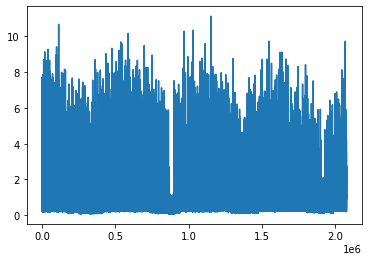

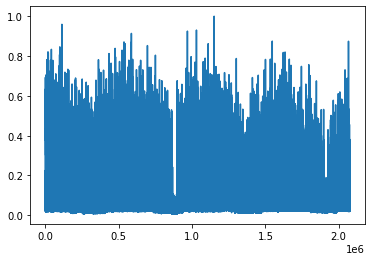

In [9]:
plt.figure(1)
plt.plot(time_from_start, global_power)
plt.figure(2)
plt.plot(time_from_start, data_time_np[:,1])

print(data_time_np[:10])

# Cluster Analysis